# Notebook for training self-driving models

### Set Constants to configure network:

In [37]:
from config import ASSETS_FOLDER

In [38]:
LOCAL = True
if LOCAL:
  assets_path = ASSETS_FOLDER
else:
  assets_path = '/content/drive/MyDrive/enph353/enph353_competition/assets/'

# Training directories
IMAGE_PATHS = [assets_path + 'images/outer_lap/final/base10000',
                assets_path + 'images/outer_lap/final/saddle1',
                assets_path + 'images/outer_lap/final/saddle2',
                assets_path + 'images/outer_lap/final/saddle3',
                assets_path + 'images/outer_lap/final/saddle4',
                assets_path + 'images/outer_lap/final/saddle5',
                assets_path + 'images/outer_lap/final/saddle6',
                assets_path + 'images/outer_lap/final/saddle7']
# Model output directory
modelpath = assets_path + 'models/outer_lap/5convlayers/final/saddle7' # path to save model to 
EPOCHS = 6
IS_GRAY = True

### install libraries

In [39]:
if not LOCAL:
  !pip install -q tensorflow==2.9.3
import tensorflow as tf
print(tf.__version__)
from keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
print()

2.9.3



In [40]:
import os
for path, dirs, files in os.walk(assets_path + 'images/outer_lap/final/'):
  print(len(os.listdir(path)), 'files', 'in', path)

8 files in /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/images/outer_lap/final/
38 files in /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/images/outer_lap/final/saddle7
53 files in /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/images/outer_lap/final/saddle6
9 files in /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/images/outer_lap/final/saddle2
95 files in /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/images/outer_lap/final/saddle1
98 files in /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/images/outer_lap/final/saddle5
9996 files in /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competi

### mount drive

In [41]:
if not LOCAL:
    from google.colab import drive
    drive.mount('/content/drive')

# Part 1: Load in data and labels

## 1.1: Load in images

In [42]:
images = []
for path in IMAGE_PATHS:
  for im in os.listdir(path)[:5]:
    images.append(path + '/' + im)
images
print('training on', sum([len(os.listdir(p)) for p in IMAGE_PATHS]), 'images.')

training on 10432 images.


## 1.2: Generate labels

In [43]:
def get_action_from_filename(filename):
  vels = [float(v) for v in filename.split(']')[0].split('[')[1].split(',')]
  if vels[1] == 0:
    return 0 # forward
  elif vels[1] > 0:
    return 1
  else:
    return 2

print("example image and label:")
for im in images[:1]:
  print('X:', im, '\nY:', get_action_from_filename(im))

example image and label:
X: /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/images/outer_lap/final/base10000/[0.36450000000000005, 0.0]2023-03-28 12:13:58.667413.png 
Y: 0


## 1.3: Organize images and labels into X and Y tensors

In [44]:
X = []
Y = []
actions = [] 
for path in IMAGE_PATHS:
  for image in os.listdir(path):
    impath = path + '/' + image
    cv_image = cv2.imread(impath)
    if IS_GRAY:
      try:
        cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)
      except:
        print(f'error converting image {impath} to grayscale')
        break
    X.append(cv_image)
    action = get_action_from_filename(image)
    Y.append(tf.one_hot(action, 3))
    actions.append(action)


X = np.array(X)
Y = np.array(Y)
indices = tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32)
idx = tf.random.shuffle(indices)
X = tf.gather(X, idx)
Y = tf.gather(Y, idx)

'X shape:', X.shape, 'Y_shape:', Y.shape

2023-04-03 21:12:56.326095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 21:12:56.326314: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fizzer/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2023-04-03 21:12:56.326363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fizzer/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2023-04-03 21:12:56.326402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libra

('X shape:', TensorShape([10432, 36, 64]), 'Y_shape:', TensorShape([10432, 3]))

In [45]:
actions[:5]

[0, 0, 0, 0, 0]

### Histogram of actions

30 36


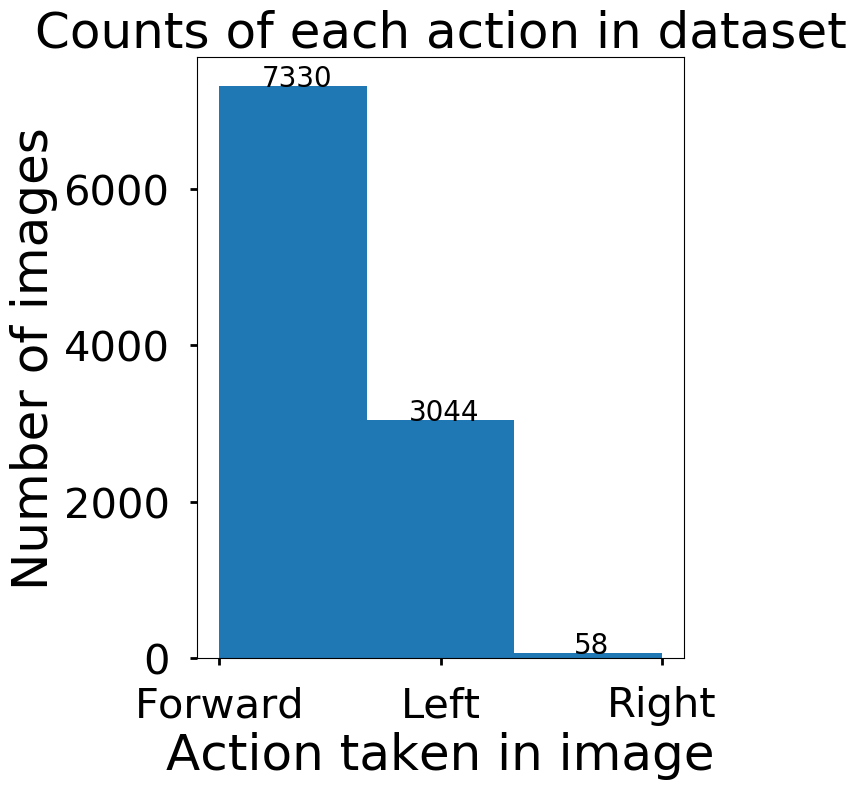

In [46]:
# create a figure
fig, ax = plt.subplots(figsize=(8, 8))

# tick fontsize and label fontsize
tick_size = 30
label_size = 36

print(tick_size, label_size)

num_bins = 3
n, bins, patches = ax.hist(actions, bins=num_bins)

# Add numbers on the top of each bar
for i in range(num_bins):
    if n[i] > 0:
        ax.text(bins[i] + 0.35, n[i], str(int(n[i])), fontsize=20, ha='center')
ax.set_title('Counts of each action in dataset', fontsize=label_size)

ax.tick_params(pad=15, length=5, width=2, labelsize=tick_size)
ax.set_xlabel('Action taken in image', fontsize=label_size)
ax.set_ylabel('Number of images', fontsize=label_size)

ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Forward', 'Left', 'Right'])

fig.tight_layout()

## 1.4 Split data into training and validation splits

In [47]:
train_split = 0.9
N = int(X.shape[0] * train_split)
X_train = X[:N]
Y_train = Y[:N]
X_valid = X[N:]
Y_valid = Y[N:]
'X_train:', X_train.shape, 'X_valid: ', X_valid.shape

('X_train:',
 TensorShape([9388, 36, 64]),
 'X_valid: ',
 TensorShape([1044, 36, 64]))

### Test random image and its label

Text(0.5, 1.0, 'Random example... Label: tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)')

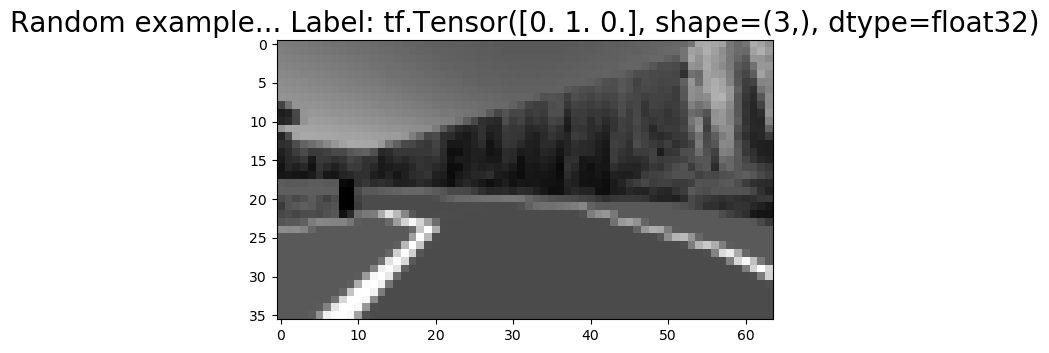

In [48]:
N = 1 # Rerun for more random images
idx = np.random.randint(0, X.shape[0]) # sample from X
plt.imshow(X[idx], cmap='gray')
plt.title('Random example... Label: ' + str(Y[idx]), size=20)

# Part 2: Train Model

In [49]:
model = None
model = models.Sequential()
model.add(layers.Conv2D(24, (3,3), strides=(2,2), activation='relu', input_shape=(36, 64, 1)))
model.add(layers.Conv2D(36, (3,3), strides=(1,1), activation='relu'))
model.add(layers.Conv2D(48, (3,3), strides=(1,1), activation='relu'))
model.add(layers.Conv2D(64, (2,2), strides=(1,1), activation='relu'))
model.add(layers.Conv2D(64, (2,2), strides=(1,1), activation='relu'))
model.add(layers.Flatten())
# model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3)) # output layer
model.add(layers.Softmax())
print("Model Summary:")
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
print('\n\n\n--------------------')
print("Train Model:")
history = model.fit(X_train, Y_train, batch_size=32, epochs=EPOCHS, 
                    validation_data=(X_valid, Y_valid))

Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 17, 31, 24)        240       
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 29, 36)        7812      
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 27, 48)        15600     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 26, 64)        12352     
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 25, 64)        16448     
                                                                 
 flatten (Flatten)           (None, 17600)             0         
                                                                 
 dense (Dense)               (None, 128) 

33/33 - 0s - loss: 0.2362 - accuracy: 0.9272 - 230ms/epoch - 7ms/step


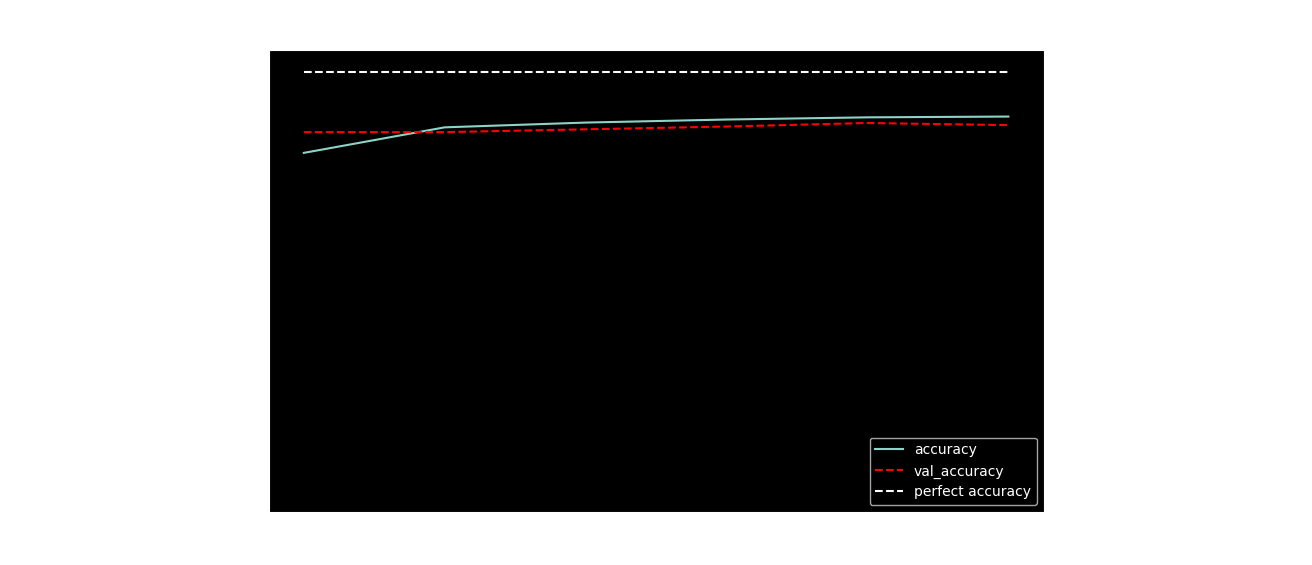

In [50]:
plt.figure(figsize=(10,6))
plt.style.use('dark_background')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy', linestyle='--', color='red')
plt.plot(range(EPOCHS), [1.0]*EPOCHS, label='perfect accuracy', linestyle='--', color='white')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1.03])
plt.legend(loc='lower right')
plt.title(f"Model Accuracy on validation and training data over {EPOCHS} epochs", size=30)


test_loss, test_acc = model.evaluate(X_valid,  Y_valid, verbose=2)

## 2.2 Visualize softmax outputs

1/1 [==============================] - 0s 12ms/step


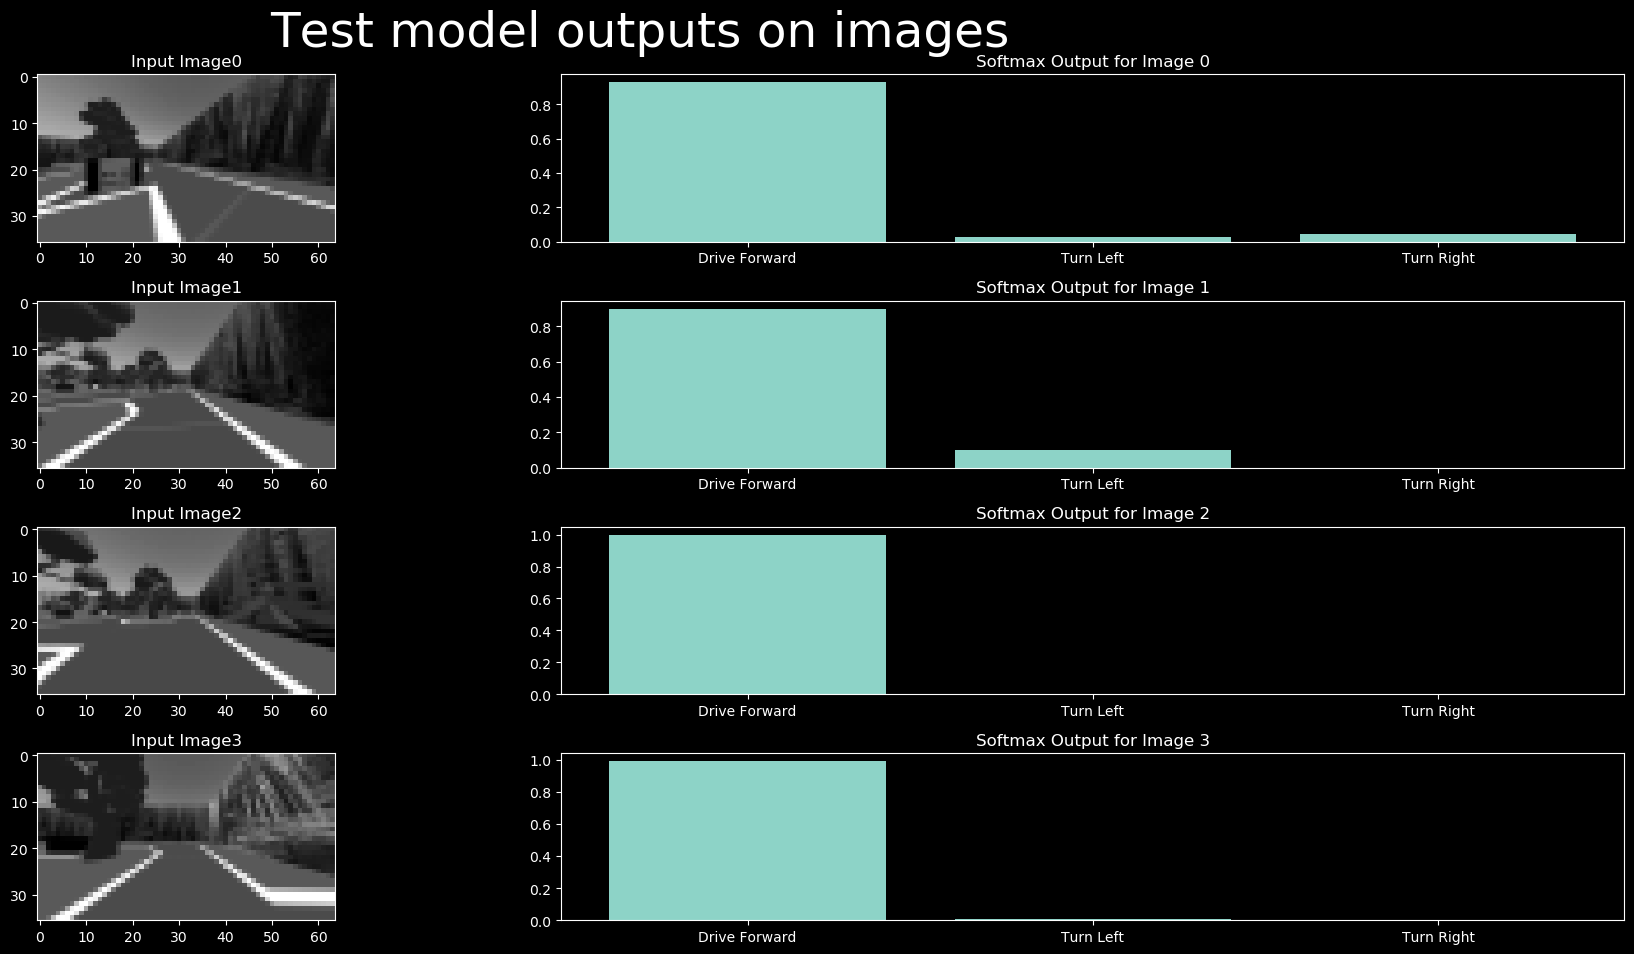

In [51]:
N = 4
fig, axs = plt.subplots(N, 2, figsize=(20,10))
fig.suptitle('Test model outputs on images', size=35)
for i in range(N):
  idx = np.random.randint(0, X_valid.shape[0])
  ypred = model.predict(tf.expand_dims(X_valid[idx], 0))
  axs[i,0].imshow(X_valid[idx], cmap='gray')
  axs[i,1].bar(['Drive Forward', 'Turn Left', 'Turn Right'], ypred.tolist()[0])
  axs[i,0].set_title('Input Image' + str(i))
  axs[i,1].set_title('Softmax Output for Image '+ str(i))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [52]:
model.save(modelpath)

INFO:tensorflow:Assets written to: /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/models/outer_lap/5convlayers/final/saddle7/assets


INFO:tensorflow:Assets written to: /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/models/outer_lap/5convlayers/final/saddle7/assets


: 